In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

stations=["BJNM_2015.txt","POMIO_2015.txt"]
DIST_filename="Dst_2000_2023.txt" # it is already cleaned before processing
datafolder="data\\"

hour_steps_for_height=39 #39 is the number of different heights
X=0.8   
past_steps=11
ap_start_index=past_steps*hour_steps_for_height # starting point to use previous values
delta_step=18
delta_X_column_size = delta_step+1

baseindex=delta_step*hour_steps_for_height+hour_steps_for_height  #delta_kps already starts from +1h(39 hoursteps), so we added hour_steps_for height
baseindex2=baseindex-ap_start_index # for apX and dist to adjust indexes
baseindex3=baseindex-hour_steps_for_height #for r_delta_h to adjust indexes



In [2]:
#reads IRI and Dist files.

df_st_merged_foF2=pd.DataFrame()

def read_edit_dist():
    
    df_dst=pd.read_csv(datafolder+DIST_filename,skiprows=17)

    df_dst['DATE']=pd.to_datetime(df_dst['DATE'])

    mask_for_24h_format = (df_dst['TIME'] == '00:00:00.000')
    df_dst.loc[mask_for_24h_format,'TIME'] = df_dst.loc[mask_for_24h_format,'TIME'].replace('00:00:00.000','24:00:00.000',regex=True)
    df_dst.loc[mask_for_24h_format,'DATE'] = df_dst.loc[mask_for_24h_format,'DATE']- timedelta(days=1)
    df_dst.loc[mask_for_24h_format,'DOY'] = df_dst.loc[mask_for_24h_format,'DOY']-1

    return df_dst

df_dst=read_edit_dist()

In [3]:
#Plots rowxcol grid for foF2 dataset
def plot_data(location,year,foF2_data,colSize,rowSize):
#dont forget to iterate with step hour_steps_for_height=39 to see date over time.

    fig, axs = plt.subplots(nrows=rowSize, ncols=colSize, figsize=(24, 16))
    fig.suptitle(location+' foF2 Dataset Plots For '+year, fontsize=16)
    fig.subplots_adjust(hspace=0.5)

    row_index=0
    col_index=0

    for col in foF2_data.columns[4:-2]: #excluded foF2 and Distance 
        axs[row_index, col_index].plot(foF2_data["Date"][::hour_steps_for_height],foF2_data[col][::hour_steps_for_height])
        axs[row_index, col_index].set_title(col)

        col_index+=1

        if col_index==3:
            col_index=0
            row_index+=1

    fig.savefig("graphs/"+location+"_"+year+"_foF2_dataset.jpg",dpi=500,bbox_inches='tight')    

### Kp Regression
1. We need to achieve stationarity of the Kp index and take the first differences of the Kp index. This involves subtracting each value from its previous value, which can remove trends and make the data more stationary. The formula for the first differences in the Kp index is: ΔKp(t) = Kp(t) - Kp(t-1)
2. We can then use this transformed series of data in the autoregression model: ΔKp(t) = β0 + β1*ΔKp(t-1) + β2*ΔKp(t-2) + ... + β18*ΔKp(t-18) + ε(t), Note that the first differences model uses ΔKp instead of Kp and ΔKp(t-1) instead of Kp(t-1) in the autoregression model.
3. We can estimate the coefficients of the autoregression model using the least squares method. To do this, we need to collect the last 19 values of the Kp index, i.e., Kp(t-18) to Kp(t), and use them to fit the model. The formula for the estimated coefficients is: β = (X'X)^(-1)X'Y,
where X is a matrix of size (n-18) x 19) that contains the lagged Kp values, and Y is a vector of size (n-18) x 1 that includes the Kp index values for the same time period. The first row of X contains the Kp values at time t-18 to t-1, the second row includes the Kp values at time t-17 to t, and so on, up to the last row which contains the Kp values at time t-1 to t-18. The intercept term β0 is represented by a column of 1s in X.

In [4]:
def get_ap_data(data_len,ap_3h):

    ap_total=np.array([])
    for ap3hstep in range(ap_start_index,data_len,hour_steps_for_height):
        ap_elem=0

        for step in range(past_steps,-1,-1):
            ap_elem+=(ap_3h[ap3hstep-hour_steps_for_height*step]*X**step) #ap_x calculation with respect to last 33h + current time

        ap_total=np.append(ap_total,np.repeat((1-X)*ap_elem,hour_steps_for_height)) # repeating for heights
    return ap_total
    
def get_dst_data(dsts):
    
    dst_total=np.array([])
    for dst_step in range(past_steps,len(dsts)): 
        
        dst_elem=0
        for step in range(past_steps,-1,-1):
            dst_elem+=(dsts[dst_step-step]*X**step) #same calculation with ap

        dst_total=np.append(dst_total,np.repeat((1-X)*dst_elem,hour_steps_for_height))

    return dst_total
        
def get_kp_data(kps):
    
    delta_kp_total=np.array([])
    delta_kps=np.array([])                     
    for kp_index in range(hour_steps_for_height,len(kps),hour_steps_for_height):
        delta_kps=np.append(delta_kps,kps[kp_index]-kps[kp_index-hour_steps_for_height])



    delta_X = np.zeros((len(delta_kps)-18, delta_X_column_size))
    delta_Y = np.array([])

    for i in range(delta_step,len(delta_kps)):
            delta_X[i-delta_step,:] = np.concatenate([[1],delta_kps[i-delta_step:i][::-1]])
            delta_Y=np.append(delta_Y,delta_kps[i])

    # compute the least squares solution
    kp_betas = np.linalg.inv(delta_X.T.dot(delta_X)).dot(delta_X.T).dot(delta_Y)
    for i in range(delta_step,len(delta_kps)):
        delta_kp_total=np.append(delta_kp_total,np.repeat(get_new_delta_kps(kp_betas,delta_kps[i-delta_step:i][::-1]),hour_steps_for_height))
    
    return delta_kp_total


def get_new_delta_kps(kp_betas,past_kps):
    
    kp_at_t=kp_betas[0]
    for (beta,delta) in zip (kp_betas[1:],past_kps):
        kp_at_t+=beta*delta
    
    return kp_at_t

def get_r_delta_h(foF2):

    r_delta_h_total=np.array([])
    for foF2_index in range(hour_steps_for_height,len(foF2),hour_steps_for_height):
        
        delta1h=foF2[foF2_index]-foF2[foF2_index-1]
        # delta1h_previous=foF2[foF2_index-1]-foF2[foF2_index-2]
        # delta2h=delta1h-delta1h_previous          #they don't use delta2h in the paper,either.
        
        r_delta_h_total=np.append(r_delta_h_total,np.repeat(delta1h/foF2[foF2_index],hour_steps_for_height))

    # print(r_delta_h.shape)
    return r_delta_h_total

2015 BJNM
IRI:  (341640, 58)
DIST:  (8760, 4) Matched Len:  341640
syncronized

(340899, 21)
       Date  DOY  Hour  Height     HourS  HourC      CHIS      CHIC       DNS  \
0  2015-1-1    1  20.0   100.0 -0.866025    0.5  0.039803  0.999208  0.017452   
1  2015-1-1    1  20.0   150.0 -0.866025    0.5  0.039803  0.999208  0.017452   
2  2015-1-1    1  20.0   200.0 -0.866025    0.5  0.039803  0.999208  0.017452   
3  2015-1-1    1  20.0   250.0 -0.866025    0.5  0.039803  0.999208  0.017452   
4  2015-1-1    1  20.0   300.0 -0.866025    0.5  0.039803  0.999208  0.017452   
5  2015-1-1    1  20.0   350.0 -0.866025    0.5  0.039803  0.999208  0.017452   
6  2015-1-1    1  20.0   400.0 -0.866025    0.5  0.039803  0.999208  0.017452   
7  2015-1-1    1  20.0   450.0 -0.866025    0.5  0.039803  0.999208  0.017452   
8  2015-1-1    1  20.0   500.0 -0.866025    0.5  0.039803  0.999208  0.017452   
9  2015-1-1    1  20.0   550.0 -0.866025    0.5  0.039803  0.999208  0.017452   

        DNC  ..

C:\Users\srknm\AppData\Local\Temp\ipykernel_14360\3892546773.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DIST.drop(sync_i/hour_steps_for_height, axis=0, inplace=True)


syncronized

(326508, 21)
       Date  DOY  Hour  Height     HourS  HourC     CHIS      CHIC       DNS  \
0  2015-1-1    1  20.0   100.0 -0.866025    0.5  0.02662  0.999646  0.017452   
1  2015-1-1    1  20.0   150.0 -0.866025    0.5  0.02662  0.999646  0.017452   
2  2015-1-1    1  20.0   200.0 -0.866025    0.5  0.02662  0.999646  0.017452   
3  2015-1-1    1  20.0   250.0 -0.866025    0.5  0.02662  0.999646  0.017452   
4  2015-1-1    1  20.0   300.0 -0.866025    0.5  0.02662  0.999646  0.017452   
5  2015-1-1    1  20.0   350.0 -0.866025    0.5  0.02662  0.999646  0.017452   
6  2015-1-1    1  20.0   400.0 -0.866025    0.5  0.02662  0.999646  0.017452   
7  2015-1-1    1  20.0   450.0 -0.866025    0.5  0.02662  0.999646  0.017452   
8  2015-1-1    1  20.0   500.0 -0.866025    0.5  0.02662  0.999646  0.017452   
9  2015-1-1    1  20.0   550.0 -0.866025    0.5  0.02662  0.999646  0.017452   

        DNC  ...  F10.7     DST_t      AP_x  Delta_Kp        DS        DC  \
0  0.999848  ...

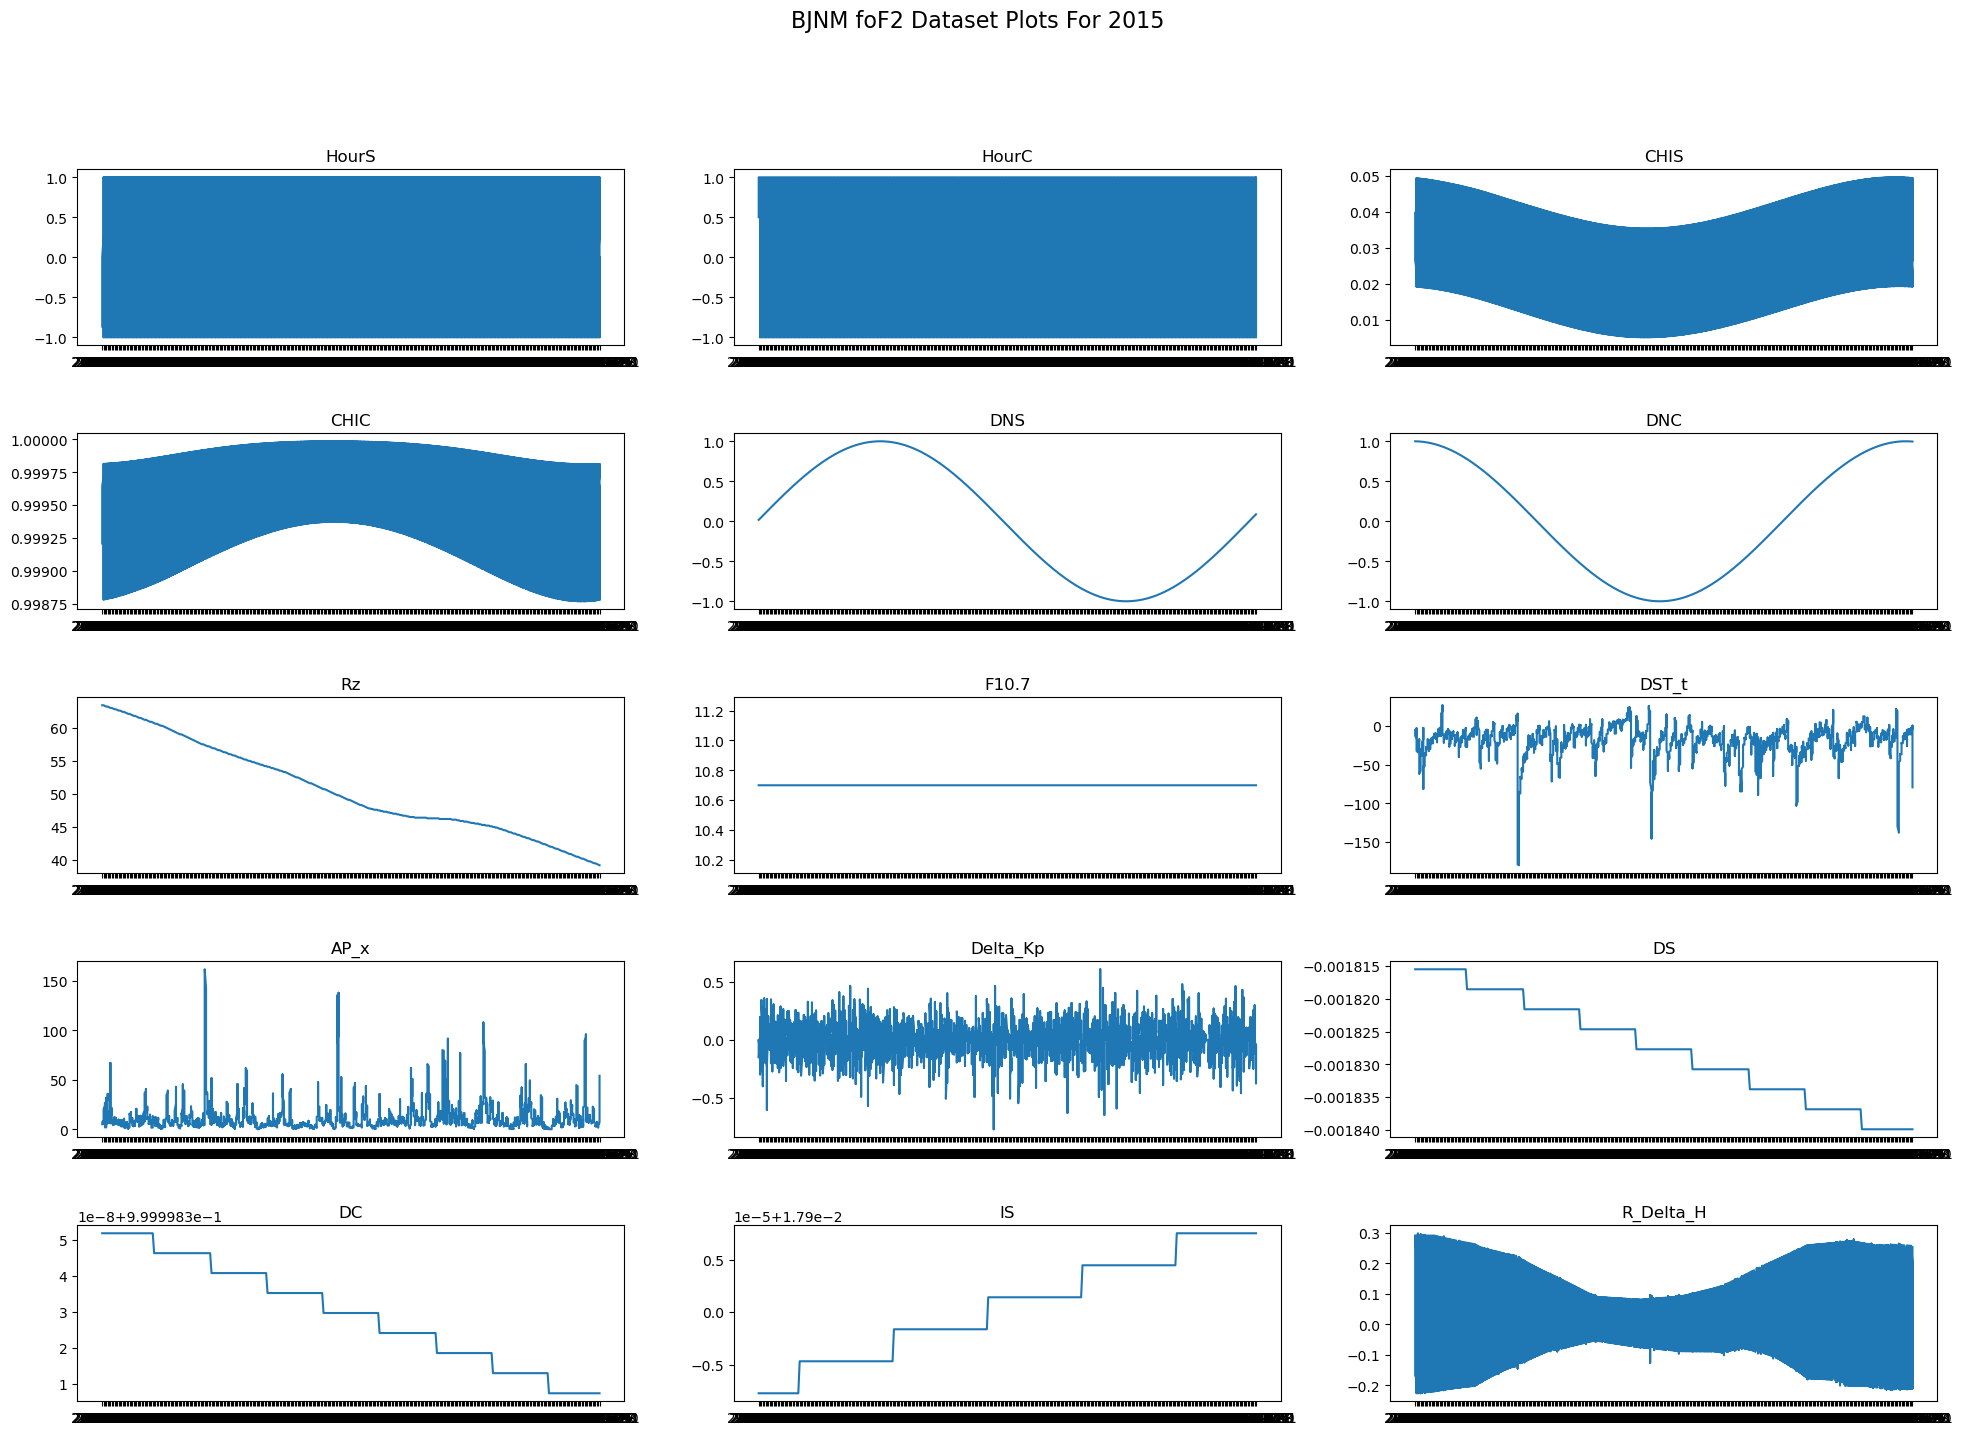

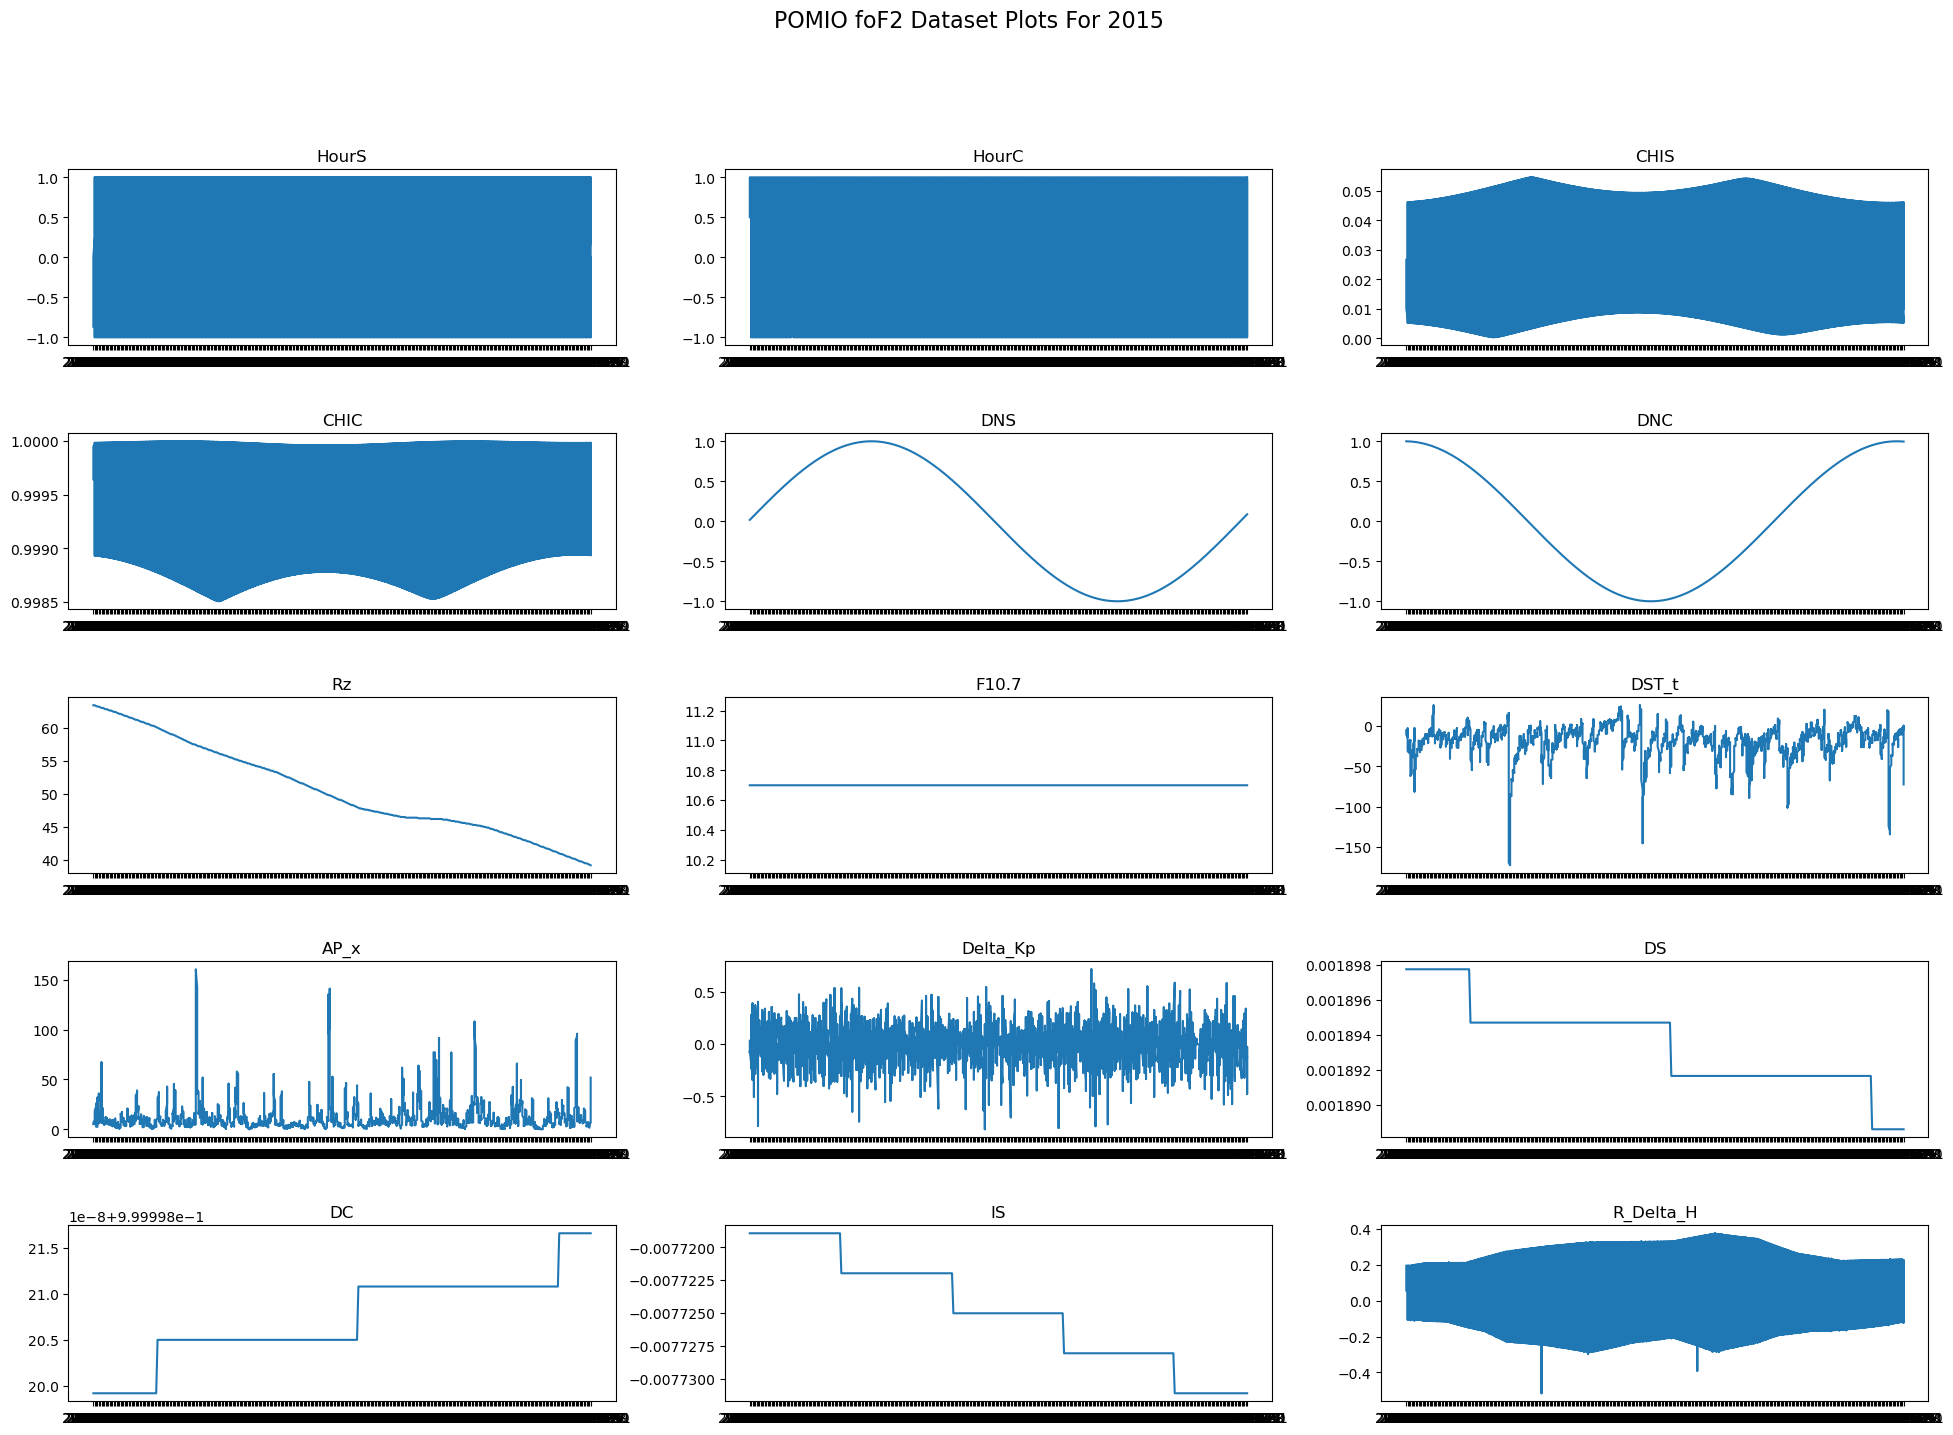

In [5]:
for st in stations:

    IRI_filename=st       # be sure of deleting all other non-numeric values before first section
    year=IRI_filename[IRI_filename.index("_")+1:IRI_filename.index(".")]
    location=IRI_filename[:IRI_filename.index("_")]
    print(year,location)

    date_start = pd.to_datetime(year+'-01-01')
    date_end = pd.to_datetime(year+'-12-31')

    column_names=[]  
    
    with open(datafolder+IRI_filename) as file:
        for line in file.readlines()[1:59]:
            column_names.append(line[line.find(' ')+1:].strip().replace(" ", ""))

        
    df_IRI=pd.read_csv(datafolder+IRI_filename, skiprows=61,header=None,delim_whitespace=True)
    df_IRI.columns=column_names

    df_DIST=df_dst
    df_DIST=df_DIST.loc[(df_DIST['DATE'] >= date_start) & (df_DIST['DATE'] <= date_end)]
    df_DIST.reset_index(drop=True, inplace=True)
    
    print("IRI: ",df_IRI.shape)
    print("DIST: ",df_DIST.shape, "Matched Len: ", len(df_DIST)*hour_steps_for_height) #365x24 row

    if(len(df_IRI)<len(df_DIST)*hour_steps_for_height):   
        print("IRI has missing data for some hours. Syncronize!!")


    #deleting some values from df_dist in order to syncronize both dataframe
    sync_i=0
    while sync_i < len(df_IRI):
        if int(df_IRI["Hour"][sync_i]) != int(df_DIST["TIME"][sync_i/hour_steps_for_height][0:2]):
            df_DIST.drop(sync_i/hour_steps_for_height, axis=0, inplace=True)
            df_DIST=df_DIST.reset_index(drop=True)
            continue
        sync_i+=hour_steps_for_height

    if(len(df_IRI)== len(df_DIST)*hour_steps_for_height):
        print("syncronized\n") 

    # print(df_IRI.shape)
    # print(df_DIST.shape) #365x24 row for each station
    # for i in range(0,len(df_IRI),hour_steps_for_height):
    #     print(df_IRI["Hour"][i],df_DIST["TIME"][i/hour_steps_for_height])



    #the columns we use for generating new dataset.Season information is not included

    dates=df_IRI.apply(lambda row: '-'.join([str(int(row['Year'])), str(int(row['Month'])),str(int(row['Day']))]), axis=1).to_numpy()
    hours=df_IRI["Hour"].to_numpy()
    heights=df_IRI["Height,km"].to_numpy()
    solar_zenith_angles=df_IRI["Solar_zenith_angle,degree"].to_numpy()
    sun_spot_number=df_IRI["Rz12"].to_numpy()
    days_of_year= df_IRI["DOY"].to_numpy()
    declination=df_IRI["Declination,degree"].to_numpy()
    inclination=df_IRI["Dip,degree"].to_numpy()
    latitude=df_IRI["Latitude,degree"].to_numpy()
    longitude=df_IRI["Longitude,degree"].to_numpy()
    ap_3h=df_IRI["3-h_ap"].to_numpy()
    dsts=df_DIST["DST"].to_numpy()
    kps=df_IRI["3-h_kp"].to_numpy()
    foF2=df_IRI["foF2,MHz"].to_numpy()

    
    hours_sin=np.sin(2*np.pi*hours/24) #in radian
    hours_cos=np.cos(2*np.pi*hours/24) #in radian

    solar_zenith_angles_sin=np.sin(2*np.pi*np.deg2rad(solar_zenith_angles)/360) #in radian (it  was originally degree)
    solar_zenith_angles_cos=np.cos(2*np.pi*np.deg2rad(solar_zenith_angles)/360) #in radian

    days_of_year_sin=np.sin(2*np.pi*days_of_year/360) #in radian
    days_of_year_cos=np.cos(2*np.pi*days_of_year/360) #in radian

    solar_activity_constant=np.full((len(df_IRI),),10.7) #it is constant, calculated as 10.7 cm.

    #Geomagnetic Activity-->dst,kp,ap
    ap_X=get_ap_data(len(hours),ap_3h)        # calculated w.r.t formula in the article.
    dst_t=get_dst_data(dsts)                  # calculated w.r.t ap_X formula.
    delta_kp_regressed=get_kp_data(kps)          # calculated w.r.t formula in the comment below

    #Neutral Air Wind-->ds,dc,is

    declination_sin=np.sin(2*np.pi*np.deg2rad(declination)/360) #in radian (it  was originally degree)
    declination_cos=np.cos(2*np.pi*np.deg2rad(declination)/360) #in radian

    inclination_sin=np.sin(2*np.pi*np.deg2rad(inclination)/360) #in radian (it  was originally degree)

    ##########################################################################################

    #Geographic Coordinates-->lats,latc,lons,lonc

    latitude_sin=np.sin(2*np.pi*np.deg2rad(latitude)/180) #in radian (it  was originally degree)
    latitude_cos=np.cos(2*np.pi*np.deg2rad(latitude)/180) #in radian

    longitude_sin=np.sin(2*np.pi*np.deg2rad(longitude)/360) #in radian (it  was originally degree)
    longitude_cos=np.cos(2*np.pi*np.deg2rad(longitude)/360) #in radian

###########################################################################################
   
    #r_delta_h
    r_delta_h=get_r_delta_h(foF2)

    #distance to the equator is added,too. in km
    distance=np.abs(latitude)*69*1.6

    #original foF2 is also being added as our output.
    
    ###########################################################################################
    
    #Generates foF2 dataset
    # data_dictionary={"Date":dates[baseindex:],"Hour":hours[baseindex:],"Height":heights[baseindex:],"HourS":hours_sin[baseindex:],"HourC":hours_cos[baseindex:],"CHIS":solar_zenith_angles_sin[baseindex:],\
    #     "CHIC":solar_zenith_angles_cos[baseindex:],"DNS":days_of_year_sin[baseindex:],"DNC":days_of_year_cos[baseindex:],"F10.7":solar_activity_constant[baseindex:],\
    #         "DST_t":dst_t[baseindex2:],"AP_x":ap_X[baseindex2:],"Delta_Kp":delta_kp_regressed,"DS":declination_sin[baseindex:],"DC":declination_cos[baseindex:],\
    #             "IS":inclination_sin[baseindex:],"LATS":latitude_sin[baseindex:],"LATC":latitude_cos[baseindex:],"LONS":longitude_sin[baseindex:],"LONC":longitude_cos[baseindex:],\
    #                 "R_Delta_H":r_delta_h[baseindex3:],"EqDistance":distance[baseindex:],"foF2":foF2[baseindex:]}

    #edited ver.

    data_dictionary={"Date":dates[baseindex:],"DOY":days_of_year[baseindex:],"Hour":hours[baseindex:],"Height":heights[baseindex:],"HourS":hours_sin[baseindex:],"HourC":hours_cos[baseindex:],"CHIS":solar_zenith_angles_sin[baseindex:],\
    "CHIC":solar_zenith_angles_cos[baseindex:],"DNS":days_of_year_sin[baseindex:],"DNC":days_of_year_cos[baseindex:],"Rz":sun_spot_number[baseindex:],"F10.7":solar_activity_constant[baseindex:],\
        "DST_t":dst_t[baseindex2:],"AP_x":ap_X[baseindex2:],"Delta_Kp":delta_kp_regressed,"DS":declination_sin[baseindex:],"DC":declination_cos[baseindex:],\
            "IS":inclination_sin[baseindex:],\
                "R_Delta_H":r_delta_h[baseindex3:],"EqDistance":distance[baseindex:],"foF2":foF2[baseindex:]}

    df_foF2=pd.DataFrame(data=data_dictionary)
    print(df_foF2.shape)
    print(df_foF2.head(10))

    plot_data(location,year,df_foF2,3,5)

    df_st_merged_foF2=pd.concat([df_st_merged_foF2,df_foF2])

print("All stations merged")

In [6]:
# saves foF2 dataframe to the excel file

save_prefix=datafolder+location+year

if(len(stations)>1):
    save_prefix=datafolder+year+"_merged"

#df_st_merged_foF2.to_excel(save_prefix+"_foF2.xlsx",index=False)
df_st_merged_foF2.to_csv(save_prefix+"_foF2.txt",index=False)
